In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
import gc

In [4]:
np.random.seed(1204)

In [5]:
PATH = Path('data')

In [6]:
# reset learner
def reset_learner():
    learn=None
    gc.collect()
    learn = create_cnn(data, models.resnet50, metrics=accuracy).to_fp16()
    return learn
def reset_learner_no_fp16():
    learn=None
    gc.collect()
    learn = create_cnn(data, models.resnet50, metrics=accuracy)
    return learn
def get_data(bs,size,seed=1204):
    np.random.seed(seed)
    tfms = get_transforms(do_flip=True, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0,p_affine=0,p_lighting=0)
    return ImageDataBunch.from_folder(PATH,valid_pct=0.15,bs=bs,ds_tfms = tfms,size=size,num_workers=4).normalize(imagenet_stats)

# Create validation set for studio classification

In [ ]:
# train=['castle','beauty','howl','pocahontas']
# val = ['tarzan','mononoke']

# os.chdir('data/tarzan')

# idx = np.random.permutation(len(os.listdir()))[:500]

# imgs = os.listdir()

# src='/home/quantran/kwon/animation-classification/data/tarzan/'
# dest='/home/quantran/kwon/animation-classification/data_1/val/disney'

# for i in idx:
#     shutil.copy2(src+imgs[i],dest)

# Create data

In [8]:
bs=80

In [9]:
tfms = get_transforms(do_flip=True, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0,p_affine=0,p_lighting=0)

In [10]:
data = ImageDataBunch.from_folder(PATH,valid_pct=0.15,bs=bs,ds_tfms = tfms,size=256,num_workers=4).normalize(imagenet_stats)

In [9]:
print(data.classes)
len(data.classes),data.c

['beauty', 'castle', 'hercules', 'howl', 'kiki', 'mermaid', 'mononoke', 'mulan', 'pocahontas', 'tarzan']


(10, 10)

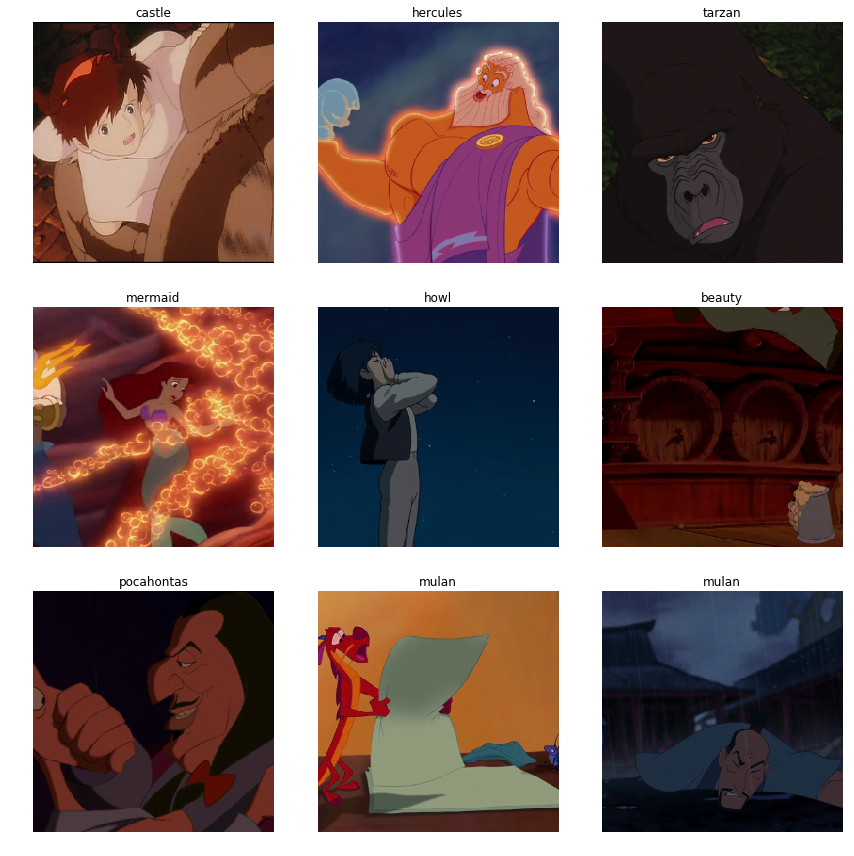

In [10]:
data.show_batch(rows=3,ds_type = DatasetType.Valid)

# Train

In [46]:
learn = create_cnn(data, models.resnet50, metrics=accuracy).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


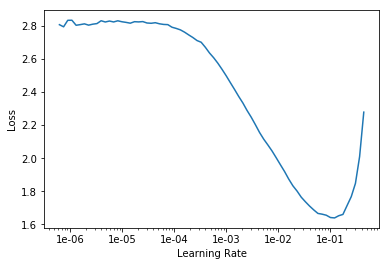

In [12]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [11]:
# studio classification
# learn.freeze()
# learn.fit_one_cycle(2,max_lr=1e-02)

In [20]:
# learn.freeze()
# learn.fit_one_cycle(3,max_lr=1e-02)

In [36]:
learn.freeze()
learn.fit_one_cycle(8,max_lr=8e-03)

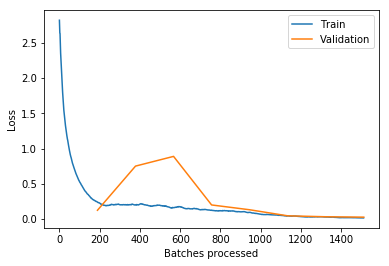

In [37]:
learn.recorder.plot_losses()

In [38]:
# learn.save(f'stage1-256-8epochs')

In [66]:
learn = reset_learner()

In [67]:
learn.load(f'stage1-256-8epochs');

In [68]:
learn.unfreeze()
learn.fit_one_cycle(5,max_lr=slice(1e-05))

In [69]:
# learn.save(f'stage2-256-5epochs');

In [34]:
# studio classification
# learn.unfreeze()
# learn.fit_one_cycle(3,max_lr=slice(1e-07))

# Interpretation

In [7]:
data = get_data(100,256)

In [8]:
learn= reset_learner_no_fp16()
learn.load('stage2-256-5epochs');

In [13]:
# learn.data.valid_dl.add_tfm(to_half)

In [11]:
interp = ClassificationInterpretation.from_learner(learn)

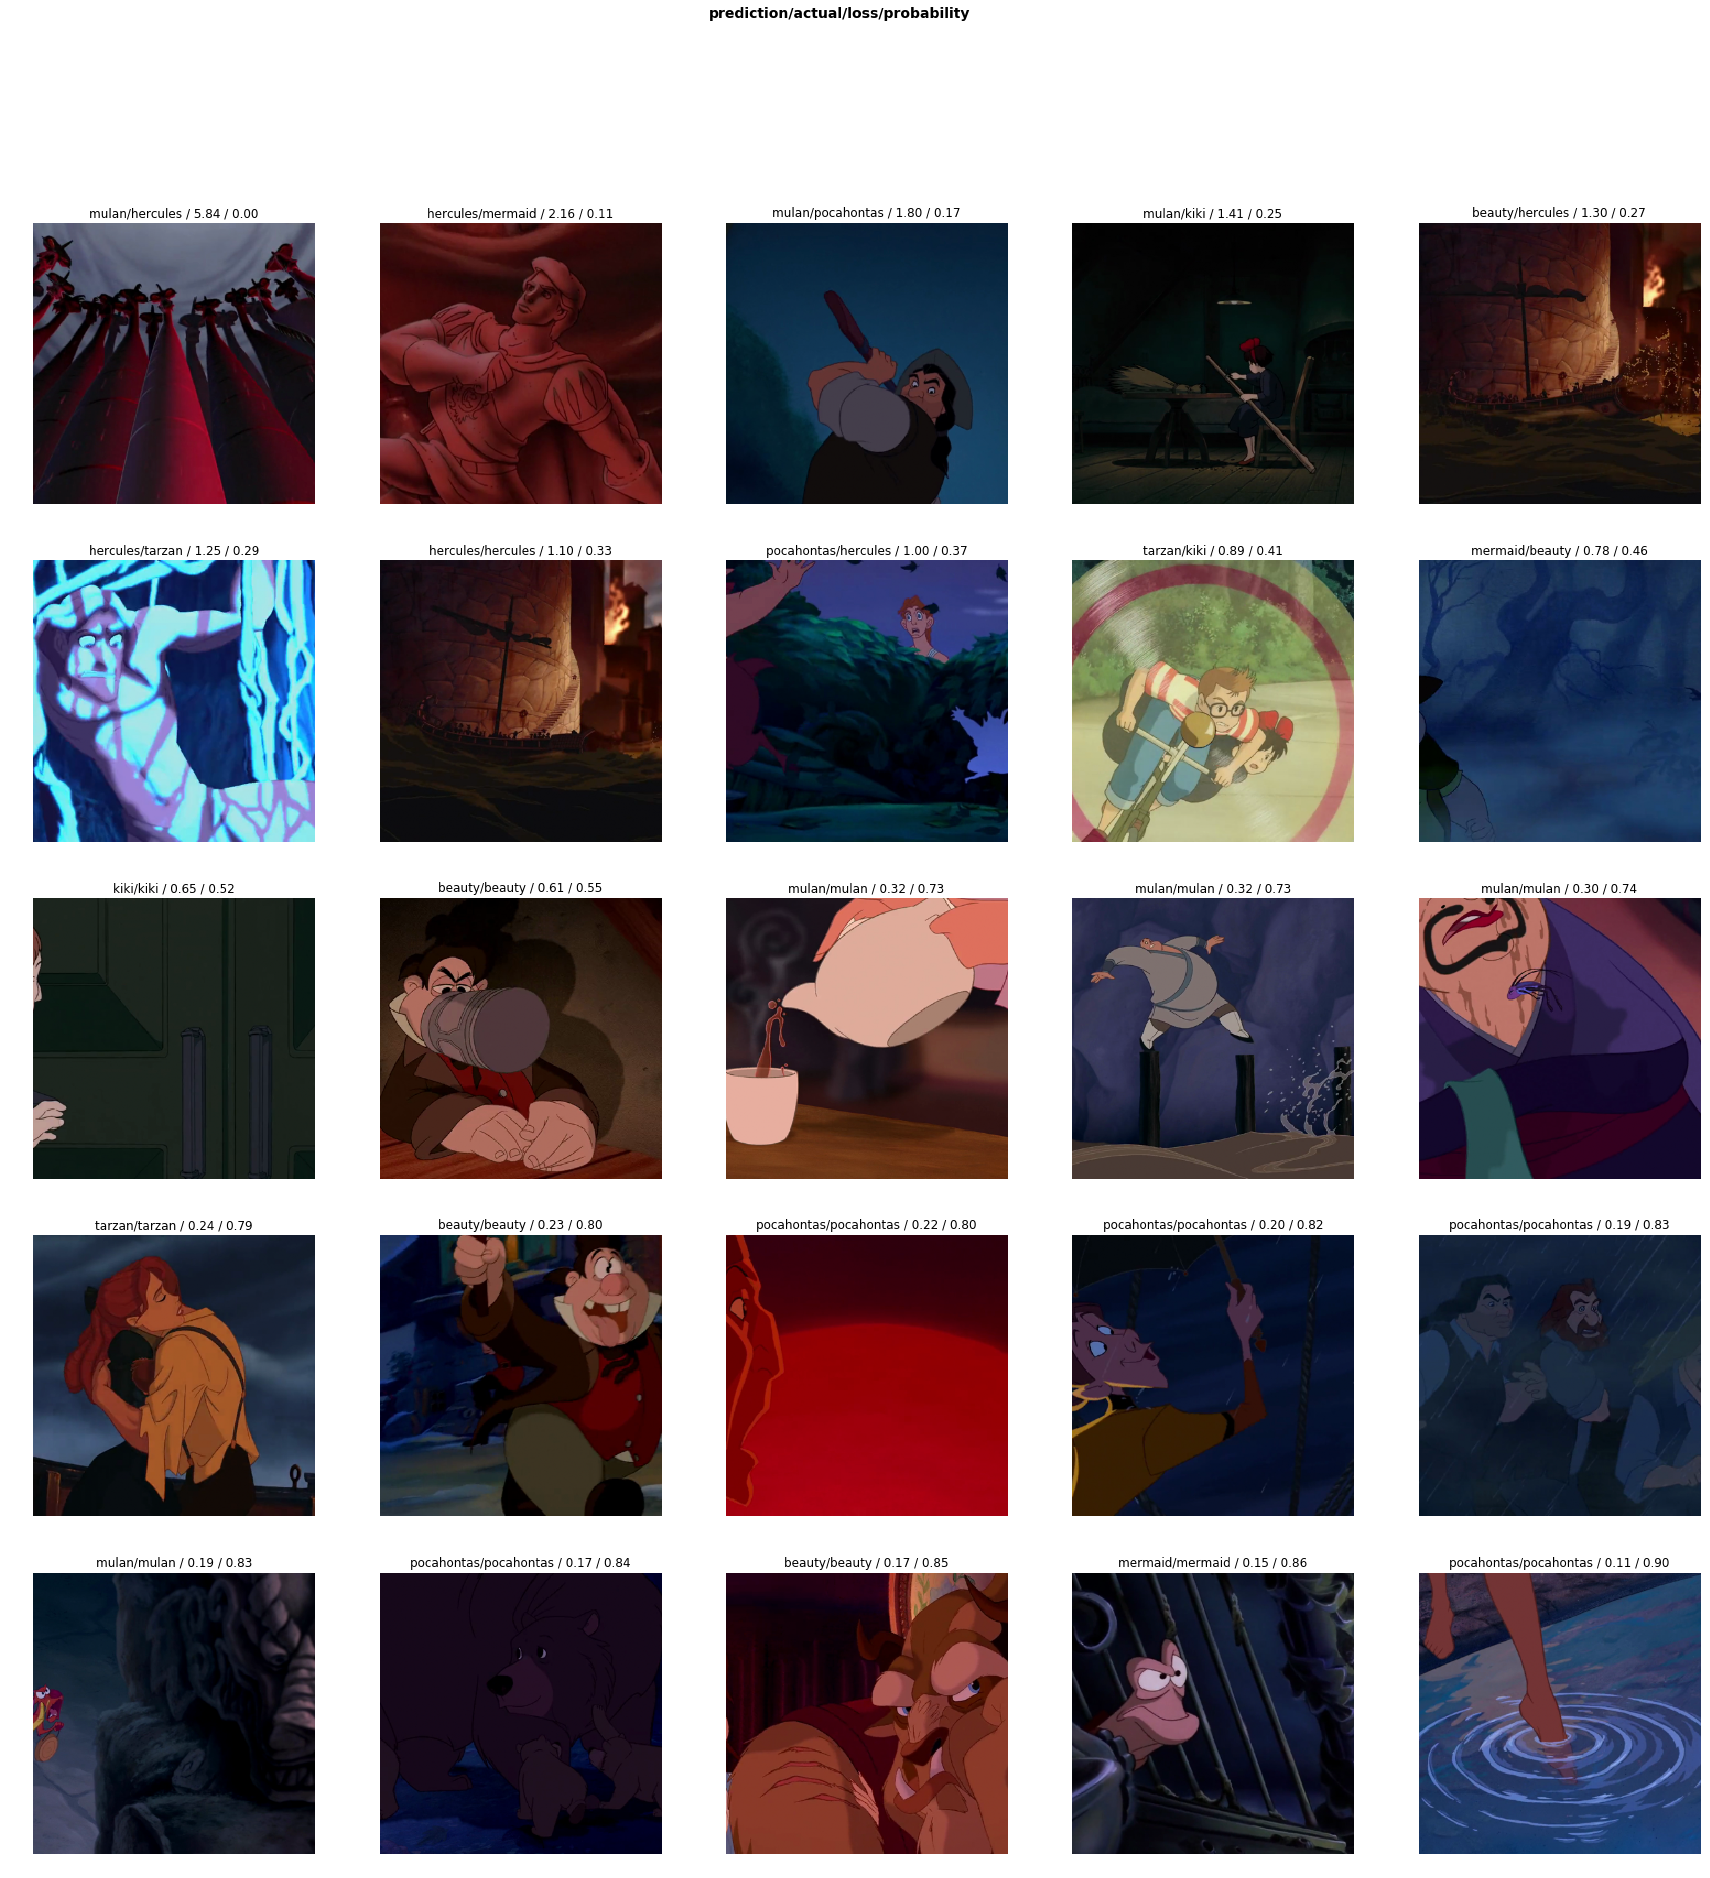

In [12]:
interp.plot_top_losses(25, figsize=(30,30))

# Gradcam

## Preparation

In [9]:
from fastai.callbacks import *

target_layer = learn.model[0][7][2]
target_layer

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
)

In [10]:
#setting up hook
fmap_hook = hook_output(target_layer)
gradient_hook = callbacks.Hook(target_layer, lambda m,inp,out: inp , is_forward=False)

## get testing image

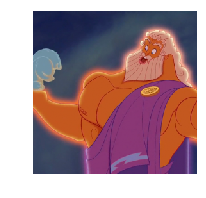

In [29]:
i = 1
learn.data.valid_ds[i][0].show()

In [30]:
imgs, labels = next(iter(learn.data.valid_dl))
img,label = imgs[i],labels[i]

In [31]:
img = img[None,...]
label = label[None,...]
img.shape,label.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1]))

## get heatmap

In [41]:
learn.model.eval();

In [42]:
# forward
learn.model.zero_grad()
out = learn.model(img)

In [43]:
onehot = torch.zeros(learn.data.c)
onehot[torch.argmax(out)] = 1.0

In [34]:
onehot

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [44]:
data.classes[torch.argmax(out).cpu().numpy()]

'hercules'

In [45]:
#backprop
out.backward(gradient=onehot.reshape(1, -1).cuda(), retain_graph=True) # what is this?

In [46]:
fmap_hook.stored.shape

torch.Size([1, 2048, 8, 8])

In [47]:
fmap_hook.stored[0][0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0174, 0.2500, 0.2386, 0.4224],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1750, 0.1555, 0.3554, 0.3492],
        [0.0000, 0.0000, 0.0000, 0.2940, 0.6567, 0.9417, 1.1260, 0.6663],
        [0.0000, 0.0000, 0.0218, 0.6965, 0.5388, 0.2157, 0.2877, 0.2705],
        [0.0000, 0.0389, 0.3966, 1.2337, 0.2453, 0.0000, 0.0000, 0.1971],
        [0.0000, 0.2116, 1.6577, 0.8708, 0.0341, 0.0000, 0.0000, 0.1413],
        [0.0000, 0.3494, 1.0357, 0.6232, 0.0000, 0.1810, 0.7261, 1.0083],
        [0.0000, 0.1110, 1.0381, 1.3528, 0.3989, 0.2335, 0.6397, 2.4837]],
       device='cuda:0')

In [48]:
gradients = next(iter(gradient_hook.stored))  # gradient of onehot w.r.t to convo layer output (7x7x512)
gradients.shape

torch.Size([1, 2048, 8, 8])

In [49]:
gradients[0][0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0008, 0.0008, 0.0008, 0.0008],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0008, 0.0008, 0.0008, 0.0008],
        [0.0000, 0.0000, 0.0000, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008],
        [0.0000, 0.0000, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008],
        [0.0000, 0.0008, 0.0008, 0.0008, 0.0008, 0.0000, 0.0000, 0.0008],
        [0.0000, 0.0008, 0.0008, 0.0008, 0.0008, 0.0000, 0.0000, 0.0008],
        [0.0000, 0.0008, 0.0008, 0.0008, 0.0000, 0.0008, 0.0008, 0.0008],
        [0.0000, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0015]],
       device='cuda:0')

In [50]:
gradient_linearization = gradients.cpu().numpy().sum((2, 3)).reshape(-1) 

In [51]:
gradient_linearization.shape

(2048,)

In [52]:
fmaps = fmap_hook.stored.cpu().numpy()
fmaps = np.squeeze(fmaps)
fmaps.shape

(2048, 8, 8)

In [53]:
heatmap = np.maximum(0, np.sum(gradient_linearization.reshape(gradient_linearization.shape[0],1,1) * fmaps,axis=0))

In [54]:
heatmap

array([[ 3.739718,  2.891947,  1.549926,  0.504178,  0.179386,  2.199382,  4.173083,  4.672873],
       [ 3.037681,  2.233603,  1.049124,  0.      ,  1.563982,  7.778832, 10.551817,  8.613223],
       [ 0.692854,  1.618604,  1.465692,  1.217045,  7.597519, 14.335908, 14.796285,  9.987993],
       [ 0.643188,  1.402008,  4.104067,  5.547044,  9.28631 , 11.487314, 11.258623,  9.759578],
       [ 3.199344,  4.106503,  6.278607,  6.820316,  5.629386,  5.630588,  7.236304,  6.536767],
       [ 2.670264,  4.341608,  6.931222,  5.795974,  2.803084,  2.379442,  4.555448,  6.410904],
       [ 1.87573 ,  2.933512,  6.719706,  5.28508 ,  2.458525,  1.462137,  4.779577,  8.166913],
       [ 2.191751,  2.276604,  5.284745,  5.652431,  0.083059,  0.      ,  4.351302,  8.282876]], dtype=float32)

## scale up heatmap and visualization

In [55]:
scale_ratio = 256/8
scale_ratio

32.0

In [56]:
import scipy.ndimage

upsampled = scipy.ndimage.zoom(heatmap, scale_ratio)
upsampled = (upsampled - np.min(upsampled))/(np.max(upsampled) - np.min(upsampled))
upsampled.shape

(256, 256)

In [57]:
def tensor_to_img(imagetensor):
    numpied = torch.squeeze(imagetensor)
    numpied = np.moveaxis(numpied.cpu().numpy(), 0 , -1)
    numpied = numpied - np.min(numpied)
    numpied = numpied/np.max(numpied)
    return numpied

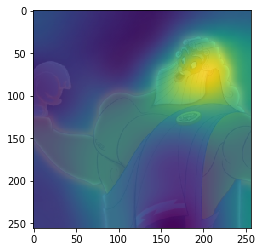

In [58]:
plt.imshow(tensor_to_img(img))
plt.imshow(upsampled, alpha=.8)


# Guided backprop

In [59]:
def clamp_gradients_hook(module, grad_in, grad_out):
    for grad in grad_in:
        torch.clamp_(grad, min=0.0)

In [60]:
relu_modules = [module[1] for module in learn.model.named_modules() if str(module[1]) == "ReLU(inplace)"]
len(relu_modules)

18

In [61]:
hooks = callbacks.Hooks(relu_modules, clamp_gradients_hook, is_forward=False)

In [62]:
learn.model.eval()
img.requires_grad_()
learn.model.zero_grad()
out = learn.model(img);

In [63]:

out.backward(gradient=onehot.reshape(1, -1).cuda(), retain_graph=True)

In [64]:
grad_img = img.grad
grad_img.shape

torch.Size([1, 3, 256, 256])

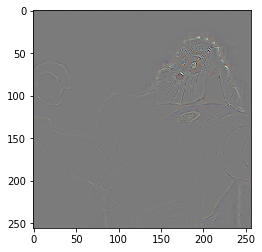

In [65]:
plt.imshow(tensor_to_img(grad_img))

In [66]:
gbp =  tensor_to_img(img.grad)

In [67]:
gbp.shape

(256, 256, 3)

In [68]:
upsampled

array([[0.275928, 0.275873, 0.275711, 0.275445, ..., 0.332294, 0.332359, 0.332396, 0.332409],
       [0.275915, 0.27586 , 0.275698, 0.275431, ..., 0.332653, 0.332717, 0.332754, 0.332766],
       [0.275872, 0.275818, 0.275655, 0.275387, ..., 0.333711, 0.333771, 0.333806, 0.333817],
       [0.275798, 0.275743, 0.275579, 0.27531 , ..., 0.335436, 0.335491, 0.335522, 0.335532],
       ...,
       [0.181856, 0.181799, 0.181635, 0.181373, ..., 0.548657, 0.550034, 0.550873, 0.551156],
       [0.182063, 0.182006, 0.181841, 0.181578, ..., 0.548522, 0.5499  , 0.550739, 0.551023],
       [0.182191, 0.182133, 0.181968, 0.181704, ..., 0.548437, 0.549815, 0.550655, 0.550939],
       [0.182235, 0.182177, 0.182011, 0.181747, ..., 0.548407, 0.549786, 0.550626, 0.55091 ]], dtype=float32)

In [69]:
prod = np.einsum('ijk, ij->ijk',gbp, upsampled)

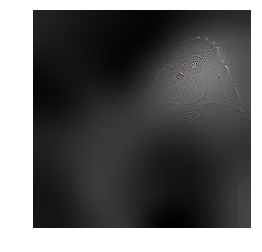

In [70]:
plt.imshow(prod)
plt.gca().set_axis_off()

# Fastai heatmap

In [96]:
data = get_data(100,256)

learn= reset_learner_no_fp16()
learn.load('stage2-256-5epochs');

Category hercules

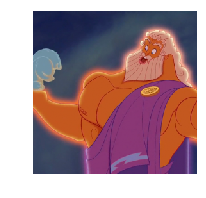

In [97]:
idx=1
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [98]:
xb,_ = data.one_item(x) #between -? and ?
xb_im = Image(data.denorm(xb)[0]) #between 0 and 1
xb = xb.cuda()

In [100]:
xb.min(),xb.max()

(tensor(-1.8501, device='cuda:0'), tensor(2.2489, device='cuda:0'))

In [101]:
m = learn.model.eval();

In [87]:
type(m)

torch.nn.modules.container.Sequential

In [90]:
m[0][-1]

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2

In [108]:
m[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Lambda()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=10, bias=True)
)

In [102]:
temp=m(xb)

In [103]:
temp[0,2]

tensor(13.4435, device='cuda:0', grad_fn=<SelectBackward>)

In [105]:
def hooked_backward(clas=y):
    with hook_output(m[0]) as hook_a: #hook at last layer of group 0's output (after bn, 512x7x7 for resnet34)
        with hook_output(m[0], grad=True) as hook_g: # gradient w.r.t to last layer of group 0's output
            preds = m(xb)
            preds[0,int(clas)].backward() # same as class onhot backprop above
    return hook_a,hook_g

In [106]:
hook_a,hook_g = hooked_backward()

In [107]:
hook_a.stored[0][0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0174, 0.2500, 0.2387, 0.4224],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1750, 0.1555, 0.3554, 0.3492],
        [0.0000, 0.0000, 0.0000, 0.2940, 0.6567, 0.9417, 1.1260, 0.6663],
        [0.0000, 0.0000, 0.0218, 0.6965, 0.5388, 0.2157, 0.2877, 0.2705],
        [0.0000, 0.0389, 0.3966, 1.2337, 0.2453, 0.0000, 0.0000, 0.1971],
        [0.0000, 0.2116, 1.6577, 0.8708, 0.0341, 0.0000, 0.0000, 0.1413],
        [0.0000, 0.3494, 1.0357, 0.6232, 0.0000, 0.1810, 0.7261, 1.0083],
        [0.0000, 0.1110, 1.0381, 1.3528, 0.3989, 0.2335, 0.6397, 2.4836]],
       device='cuda:0')

In [109]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 8, 8])

In [110]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([8, 8])

In [121]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,256,256,0),
              interpolation='bilinear');

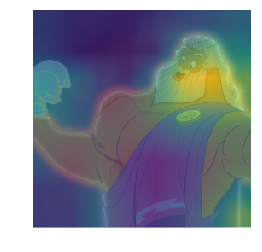

In [122]:
show_heatmap(avg_acts)

In [129]:
grad = hook_g.stored[0][0].cpu()
grad.shape

torch.Size([2048, 8, 8])

In [131]:
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([2048, 8, 8]), torch.Size([2048]))

In [132]:
mult = (acts*grad_chan[...,None,None]).mean(0)
mult.shape

torch.Size([8, 8])

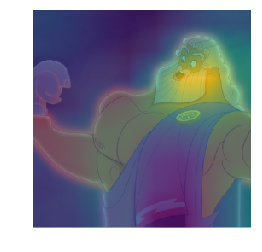

In [133]:
show_heatmap(mult)